In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-07-03 20:18:38.370988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 20:18:38.371101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 20:18:38.487856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Setting up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Setting Hyperparameters
learning_rate = 5e-5
batch_size = 128
image_size = 64
channel_img = 3
z_dim = 100
num_epochs = 10
feature_d = 64
feature_g = 64
critic_iterations = 5
lambda_GP = 10

variable = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
        [0.5 for _ in range(channel_img)], [0.5 for _ in range(channel_img)]),
    ]
)

In [5]:
# Install the Kaggle API client
!pip install kaggle

# Set your Kaggle API credentials
import os
os.environ['KAGGLE_USERNAME'] = 'engrikhlaqwahid'
os.environ['KAGGLE_KEY'] = 'ec04cfe176110d3ea06534b219f4a2d2'

# Download the CelebA dataset from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

# Create a directory to unzip the dataset
!mkdir -p /content/celeba

# Unzip the dataset into the created directory
!unzip -q celeba-dataset.zip -d /content/celeba

# List the contents of the directory to verify
!ls /content/celeba


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98%|██████████████████████████████████████▎| 1.31G/1.33G [00:11<00:00, 155MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:12<00:00, 118MB/s]
img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [6]:
# Path to the dataset
file_location = "/content/celeba"

# Create the dataset
dataset = datasets.ImageFolder(root=file_location, transform=variable)

# Create the DataLoader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Verify the DataLoader
for images, labels in loader:
    print(images.shape, labels.shape)
    break

torch.Size([128, 3, 64, 64]) torch.Size([128])


In [7]:
print(len(loader))

# Create an iterator from the DataLoader
examples = iter(loader)

# Retrieve the first batch of samples
samples, _ = next(examples)

# Print the shape of the first batch of samples
print(samples.shape)

1582
torch.Size([128, 3, 64, 64])


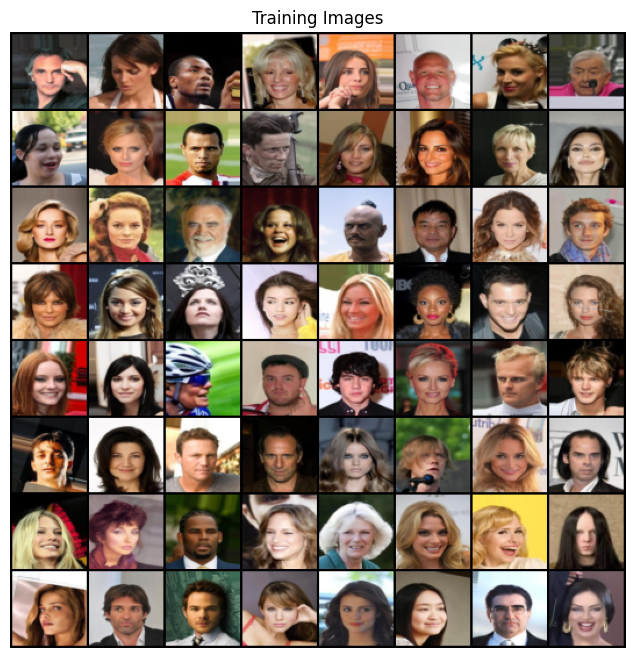

In [8]:
# Visualizing the dataset images
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
# Creating Critic Class
class Critic(nn.Module):
    def __init__(self, channel_img, feature_d):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(feature_d, feature_d*2, 4, 2, 1),
            self._block(feature_d*2, feature_d*4, 4, 2, 1),
            self._block(feature_d*4, feature_d*8, 4, 2, 1),
            nn.Conv2d(feature_d*8, 1, 4, 2, 0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine = True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [10]:
# Creating Generator Class
class Generator(nn.Module):
    def __init__(self, z_dim, channel_img, feature_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, feature_g*16, 4, 2, 0),
            self._block(feature_g*16, feature_g*8, 4, 2, 1),
            self._block(feature_g*8, feature_g*4, 4, 2, 1),
            self._block(feature_g*4, feature_g*2, 4, 2, 1),
            nn.ConvTranspose2d(feature_g*2, channel_img,4, 2, 1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

In [11]:
# Function to initialize the model weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)    # mean = 0, variance = 0.02
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 0.0,0.02)

In [12]:
def gradient_penalty(critic, real, fake, device = 'cpu'):
    batch_size, C, H, W = real.shape
    epsilon = torch.rand(batch_size,1,1,1).repeat(1,C,H,W).to(device)
    interpolated_images = real*epsilon + fake*(1-epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs = interpolated_images,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim = 1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    return gradient_penalty

In [13]:
# Creating model objects
critic = Critic(channel_img, feature_d).to(device)
gen = Generator(z_dim, channel_img, feature_g).to(device)
initialize_weights(critic)
initialize_weights(gen)

In [14]:
# Defining optimizer and loss functions
opt_critic = optim.Adam(critic.parameters(), lr = learning_rate, betas=(0.0, 0.9))
opt_gen = optim.Adam(gen.parameters(), lr= learning_rate, betas=(0.0,0.9))

In [15]:
# telling the model that the data is for training
gen.train()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [16]:
# telling the model that the data is for training
critic.train()

Critic(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [17]:
# Traning Loop
img_list = []
step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)


        for _ in range(critic_iterations):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)                                                 # G(z)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device = device)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_GP*gp
            #loss_crit.append(loss_critic)
            critic.zero_grad()
            loss_critic.backward(retain_graph = True)
            opt_critic.step()

        # Training Generator : -min E(critic(fgen_fake))
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        #loss_generator.append(loss_gen)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()


        # Printing
        if batch_idx % 100 ==0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch : {batch_idx}/{len(loader)} \
            LossD: {loss_critic:.4f}, LossG: {loss_gen:.4f}"
                 )

        step += 1

Epoch [1/10] Batch : 0/1582             LossD: 680.9911, LossG: -1.2167
Epoch [1/10] Batch : 100/1582             LossD: -133.5484, LossG: 99.8469
Epoch [1/10] Batch : 200/1582             LossD: -128.6532, LossG: 140.3906
Epoch [1/10] Batch : 300/1582             LossD: -111.6525, LossG: 154.6975
Epoch [1/10] Batch : 400/1582             LossD: -84.8020, LossG: 160.4849
Epoch [1/10] Batch : 500/1582             LossD: -68.1269, LossG: 155.2180
Epoch [1/10] Batch : 600/1582             LossD: -63.2323, LossG: 158.1623
Epoch [1/10] Batch : 700/1582             LossD: -50.2385, LossG: 164.0300
Epoch [1/10] Batch : 800/1582             LossD: -40.8132, LossG: 158.0054
Epoch [1/10] Batch : 900/1582             LossD: -38.1863, LossG: 157.4084
Epoch [1/10] Batch : 1000/1582             LossD: -28.5457, LossG: 151.5235
Epoch [1/10] Batch : 1100/1582             LossD: -23.4384, LossG: 145.0352
Epoch [1/10] Batch : 1200/1582             LossD: -20.4500, LossG: 136.7832
Epoch [1/10] Batch : 13

In [31]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in gen.state_dict():
    #print(param_tensor, "\t", critic.state_dict()[param_tensor].size())
    pass
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt_gen.state_dict():
    #print(var_name, "\t", opt_critic.state_dict()[var_name])
    pass
torch.save(gen.state_dict(), "Generator_trained.h5")

Model's state_dict:
Optimizer's state_dict:


In [32]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in gen.state_dict():
    #print(param_tensor, "\t", critic.state_dict()[param_tensor].size())
    pass
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in opt_gen.state_dict():
    #print(var_name, "\t", opt_critic.state_dict()[var_name])
    pass
torch.save(gen.state_dict(), "Generator_trained.h5")

Model's state_dict:
Optimizer's state_dict:


In [33]:
gen_1 = Generator(z_dim, channel_img, feature_g).to(device) # Load the model's state dictionary from the root directory
gen_1.load_state_dict(torch.load('Generator_trained.h5', map_location=device)) # Move the model to the correct device (redundant if the device is already set correctly)
gen_1.to(device)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [34]:
# Function to generate images from random noise
def generate_images(generator, num_images, z_dim, device):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)
        fake_images = generator(noise)
    return fake_images


In [35]:
import torchvision.utils as vutils

# Convert images to grid
def convert_images_to_grid(images, nrow=8):
    grid = vutils.make_grid(images, nrow=nrow, normalize=True)
    return grid


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def display_images(images):
    np_images = images.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    plt.show()


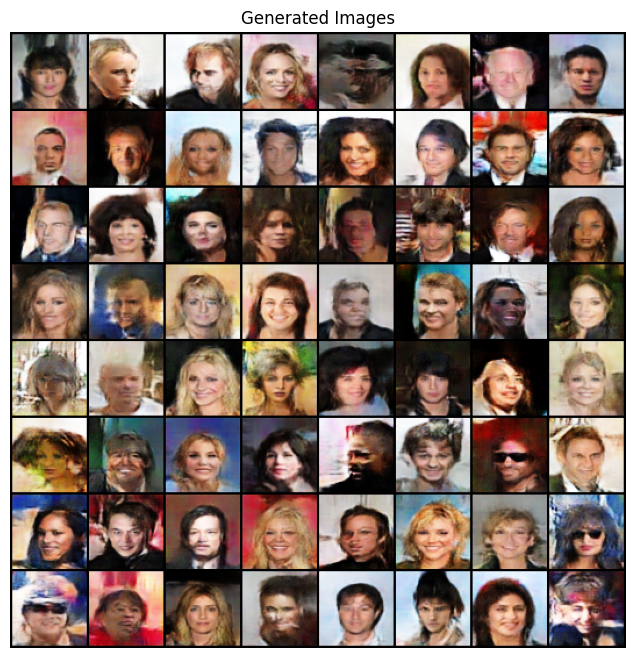

In [44]:
# Number of images to generate
num_images = 64

# Generate images
generated_images = generate_images(gen_1, num_images, z_dim, device)

# Convert images to grid
grid = convert_images_to_grid(generated_images, nrow=8)

# Display images
display_images(grid)


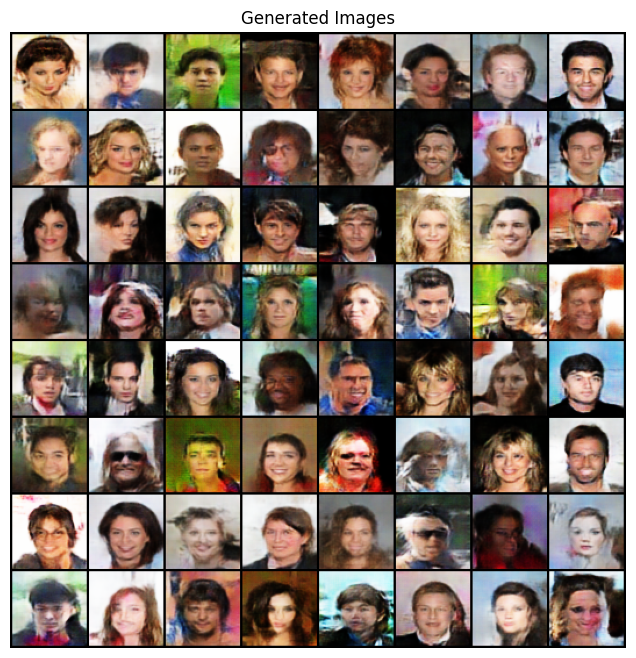

In [45]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Function to generate images from random noise
def generate_images(generator, num_images, z_dim, device):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)
        fake_images = generator(noise)
    return fake_images

# Convert images to grid
def convert_images_to_grid(images, nrow=8):
    grid = vutils.make_grid(images, nrow=nrow, normalize=True)
    return grid

# Function to display images
def display_images(images):
    np_images = images.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    plt.show()

# Number of images to generate
num_images = 64

# Generate images
generated_images = generate_images(gen_1, num_images, z_dim, device)

# Convert images to grid
grid = convert_images_to_grid(generated_images, nrow=8)

# Display images
display_images(grid)
